In [46]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as scs
import statsmodels as smm
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
import rpy2.rinterface

# 0. Reframe dataset time window

In [47]:
train=pd.read_csv('raw_train_daily.csv')
test=pd.read_csv('raw_test_daily.csv')
train_state=pd.read_csv('train_state.csv')

train=train.iloc[:,1:] #
test=test.iloc[:,1:] #
train_state=train_state.iloc[:,1:] #

In [48]:
#train period 6/22/10 - 12/26/17; test 1/2/2018 - 12/31/2019
train.iloc[:1904,:]
train.to_csv('new_train_daily.csv',index=False)

test=pd.concat([train.iloc[1904:,:],test.iloc[:338,:]])
test.to_csv('new_test_daily.csv',index=False)

# 1. HMM by R

In [49]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


iter = 1 
LL = -5816.3269306 
diff = Inf 

iter = 2 
LL = -5102.3926008 
diff = 713.9343 

iter = 3 
LL = -5092.6813804 
diff = 9.71122 

iter = 4 
LL = -5092.5606281 
diff = 0.1207523 

iter = 5 
LL = -5092.5479268 
diff = 0.01270131 

iter = 6 
LL = -5092.5458206 
diff = 0.002106203 

iter = 7 
LL = -5092.5454685 
diff = 0.0003520719 

iter = 8 
LL = -5092.5454094 
diff = 5.911296e-05 

iter = 9 
LL = -5092.5453995 
diff = 9.947682e-06 



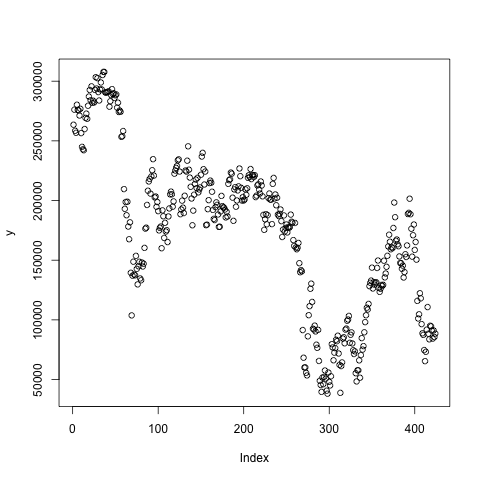

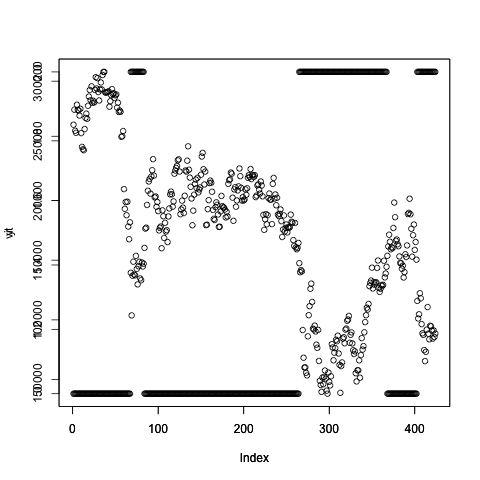

In [50]:
%%R
train <- read.csv(file ='new_train_daily.csv')
train=na.omit(train)
y=train$AM_NetPos
plot(y)

#two states from train: high(100-200), low(270-330)
library(HiddenMarkov)
library(mhsmm)
P = matrix(rep(0.5,4), byrow=TRUE, nrow=2)
delta = c(0.8, 0.2) #initial prob: 0.8/0.2, doesnt differ much from 0.5/0.5
hmm = dthmm(y, P, delta, "norm",pm = list(mean=c(mean(y[100:200]),mean(y[270:330])),sd=c(sd(y[100:200]),sd(y[270:330]))))
hmmfit = BaumWelch(hmm) #Max Likelihood est
vit = Viterbi(hmmfit) 

plot(y)
par(new=TRUE)
plot(vit,color='blue')

write.csv(vit,'train_state.csv')

# 1. Import Dataset and States (from R)

In [54]:
train=pd.read_csv('new_train_daily.csv')
test=pd.read_csv('new_test_daily.csv')
train_state=pd.read_csv('train_state.csv')

train_state=train_state.iloc[:,1:] #

In [55]:
#Original state are labelled as 2 for low and 1 for high (R)
#Now high state==1, low position state==0
train_state=2-train_state 
train_state.head()

,x
0,1
1,1
2,1
3,1
4,1


# 2. Feature generation and lag contemporary variables

In [56]:
def feature(train):
    train=train.drop(labels='Signal',axis=1)
    train=train.dropna()
    
    #1. Slope: since SPX proven to be the most predictive from Max's work
    train['SPX_1w_chg']=train['SPX']/train['SPX'].shift(1)-1 #weekly pct change
    train['SPX_2w_chg']=train['SPX']/train['SPX'].shift(2)-1 

    #2. Spread: for those highly correlated interest rates
    train['Spread_Libor_1YOIS']=train['Libor 1Y']-train['1Y OIS']

    #3. Lag: for comtemporary variables
    l=['AM_n_L', 'AM_n_S', 'Lev_n_L', 'Lev_n_S','AM_L', 'AM_S', 'Lev_L', 'Lev_S'] 
    newl=['last_'+s for s in l]
    train[newl]=train[l].shift(1)   #TS ARIMA potential
    train=train.drop(labels=l,axis=1)
    #remove signal becasue it's very sparse

    #4. Var

    #5. Cumsum

    #Comments: 1.daily signal 2.time series singal
    #train=train.drop(labels='Signal',axis=1)
    
    return train.dropna() #less the first two rows

In [57]:
#Benchmark: OLS
train=feature(train)
test=feature(test)
train_state=train_state.iloc[2:,]

In [58]:
#make sure number of weeks are the same
train.shape[0]==train_state.shape[0]

True

In [59]:
X=train.drop(columns = ['Time','AM_NetPos'])
y=train['AM_NetPos']
time_train=train['Time']

X_test=test.drop(columns = ['Time','AM_NetPos'])
y_test=test['AM_NetPos']
time_test=test['Time']

# 3. State as label in logistic regression

In [60]:
from sklearn.linear_model import LogisticRegression
y_state=np.array(train_state).reshape(len(train_state))
clf = LogisticRegression(random_state=0,max_iter=10000).fit(X.values, y_state)

In [61]:
#expected to see 1,1 because the initial states are high
clf.predict(X.iloc[:2, :].values)

array([1, 1])

In [62]:
#Test set: predicting the states for high/low
clf.predict(X_test.values)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

# 4. Different models for High/Low state: OLS

**4.1 Model**

In [63]:
from sklearn.linear_model import LinearRegression
X_high=X.iloc[np.where(train_state==1)[0]]
y_high=y.iloc[np.where(train_state==1)[0]]
X_low=X.iloc[np.where(train_state==0)[0]]
y_low=y.iloc[np.where(train_state==0)[0]]

OLS_high = LinearRegression().fit(X_high, y_high)
OLS_low = LinearRegression().fit(X_low, y_low)

**4.2 Evaluation: Training**

In [64]:
def evaluate(y,y_pred,title='Result'):
    mse=np.mean((y-y_pred)**2)
    mae=np.mean(np.abs(y-y_pred))
    ape=np.mean(np.abs((y-y_pred)/y))
    print(title,':')
    print('MSE is {}'.format(mse))
    print('MAE is {}'.format(mae))
    print('Average Percentage Error is {}'.format(ape))

In [65]:
#Train
y_pred_high=OLS_high.predict(X_high)
y_pred_low=OLS_low.predict(X_low)

evaluate(y_high,y_pred_high,title='OLS High Train')
print('\n')
evaluate(y_low,y_pred_low,title='OLS Low Train')

OLS High Train :
MSE is 42209391.345875524
MAE is 5065.279549295168
Average Percentage Error is 0.024405397034513387


OLS Low Train :
MSE is 47140897.041206434
MAE is 5551.680702205995
Average Percentage Error is 0.06797047329191966


**4.3 Inference: Test**

In [66]:
#Test
test_state=clf.predict(X_test.values)
X_high_test=X_test.iloc[np.where(test_state==1)[0]]
X_low_test=X_test.iloc[np.where(test_state==0)[0]]
y_high_test=y_test.iloc[np.where(test_state==1)[0]]
y_low_test=y_test.iloc[np.where(test_state==0)[0]]

y_pred_test_high=OLS_high.predict(X_high_test)
y_pred_test_low=OLS_low.predict(X_low_test)

In [67]:
evaluate(y_high_test,y_pred_test_high,title='OLS High Test')
print('\n')
evaluate(y_low_test,y_pred_test_low,title='OLS Low Test')

OLS High Test :
MSE is 118754917.58975862
MAE is 9033.035017233267
Average Percentage Error is 0.0552139294690154


OLS Low Test :
MSE is 973505274.7321436
MAE is 23256.348425946886
Average Percentage Error is 0.2004764354363056


In [68]:
#merge the test prediction into a single test_pred array
y_pred_test=y_test.copy()
y_pred_test.iloc[np.where(test_state==0)[0]]=y_pred_test_low
y_pred_test.iloc[np.where(test_state==1)[0]]=y_pred_test_high
evaluate(y_test,y_pred_test,title='OLS Test')

OLS Test :
MSE is 601138782.5116987
MAE is 17060.053475616194
Average Percentage Error is 0.1371937595693673


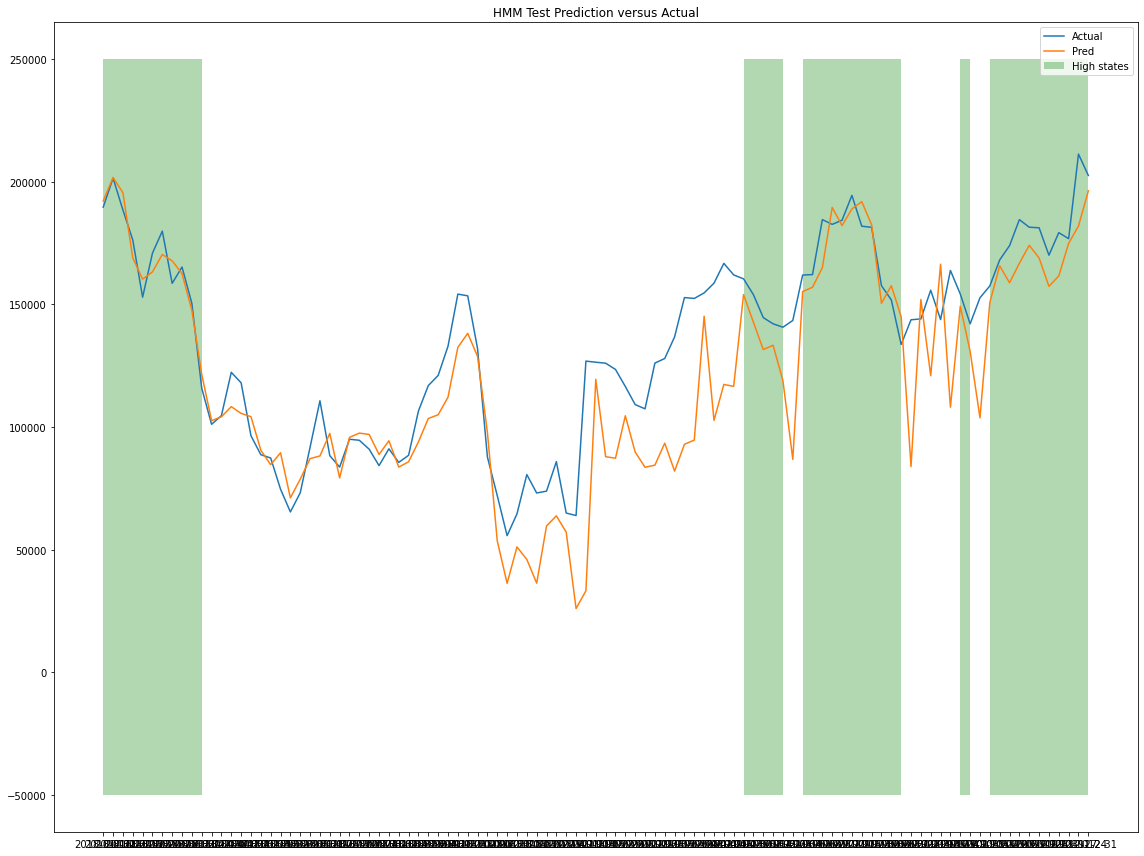

In [69]:
plt.figure(figsize=(16,12))
plt.plot(time_test,y_test,label='Actual')
plt.plot(time_test,y_pred_test,label='Pred')
plt.fill_between(time_test,-50000,250000,
                 where=(test_state==1),facecolor='green', alpha=0.3,label='High states')

plt.title('HMM Test Prediction versus Actual')
plt.legend()
plt.tight_layout()
plt.savefig('HMM Test Prediction',dpi=300)
plt.show()

Model performs well in the 'high' state with a 5.3% test AAPE as labelled in shaded green area but the performance drops significantly in the 'low' state with 38% test AAPE. Overall the model produces a test 32% AAPE. This indicated that indentifying the states which the positioning is in can be potentially helpful but the states needs more specific recognition.

In [70]:
def tsplot(y, lags=None, figsize = (10,8), style = 'bmh',title='Time Series of Log Ret',save='False'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan = 2)
        acf_ax = plt.subplot2grid(layout, (1,1))
        qq_ax = plt.subplot2grid(layout, (1,0))
        y.plot(ax = ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags = lags, ax=acf_ax,alpha = 0.05)
        sm.qqplot(y, line = 's', ax=qq_ax)
        qq_ax.set_title('QQ PLot')
        plt.tight_layout()
        if save:
            plt.savefig(title,dpi=300)
    return

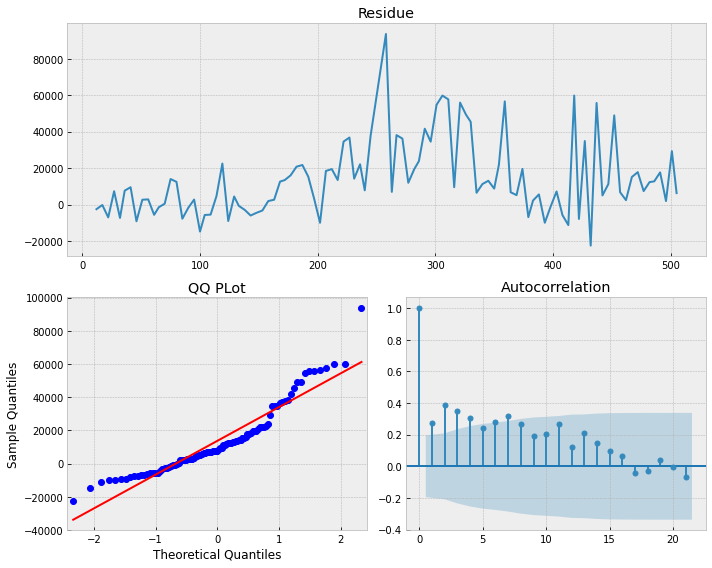

In [71]:
#look at the residue
tsplot(y_test-y_pred_test,title='Residue',save='True')

The prediction error has serial correlation up to lag 3. Residues are mostly positive indicating the model tends to over-estimate.

Error in high/low
y as diff